### LOAD MODELS

In [14]:
from model.Conv_LSTM_patch import CNN_LSTM_Model
from dataset.dataset import WikiArtDataset

import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

model = CNN_LSTM_Model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.load_state_dict(torch.load("checkpoints\cnn_lstm_patch_model.pth"))

c:\Users\adith\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adith\miniconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\adith\AppData\Local\Temp\ipykernel_14248\1361089148.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

<All keys matched successfully>

### LOAD DATASET

In [24]:
test_csv = r"csv_files\val_data.csv"
img_dir = r"F:\GSoc_2025\wiki_art_dataset\wikiart"
tran = transforms.Compose([
    transforms.Resize((224, 224)),
])


test_dataset = WikiArtDataset(test_csv, img_dir, tran)

### CREATE DATALOADER

In [25]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

### LOAD CLASS NAMES

In [26]:
import csv

def load_class_names(csv_path):
    with open(csv_path, "r", encoding='utf-8') as f:
        reader = csv.reader(f)
        class_dict = {int(row[0]): row[1] for row in reader}
    return [class_dict[i] for i in sorted(class_dict)]

artist_classes = load_class_names(r"csv_files\class_lables\artist_class.csv")
genre_classes = load_class_names(r"csv_files\class_lables\genre_class.csv")
style_classes = load_class_names(r"csv_files\class_lables\style_class.csv")

print("artist classes:", artist_classes)
print("genre classes:", genre_classes)
print("style classes:", style_classes)


artist classes: ['boris-kustodiev', 'camille-pissarro', 'childe-hassam', 'claude-monet', 'edgar-degas', 'eugene-boudin', 'gustave-dore', 'ilya-repin', 'ivan-aivazovsky', 'ivan-shishkin', 'john-singer-sargent', 'marc-chagall', 'martiros-saryan', 'nicholas-roerich', 'pablo-picasso', 'paul-cezanne', 'pierre-auguste-renoir', 'pyotr-konchalovsky', 'raphael-kirchner', 'rembrandt', 'salvador-dali', 'vincent-van-gogh', 'hieronymus-bosch', 'leonardo-da-vinci', 'albrecht-durer', 'edouard-cortes', 'sam-francis', 'juan-gris', 'lucas-cranach-the-elder', 'paul-gauguin', 'konstantin-makovsky', 'egon-schiele', 'thomas-eakins', 'gustave-moreau', 'francisco-goya', 'edvard-munch', 'henri-matisse', 'fra-angelico', 'maxime-maufra', 'jan-matejko', 'mstislav-dobuzhinsky', 'alfred-sisley', 'mary-cassatt', 'gustave-loiseau', 'fernando-botero', 'zinaida-serebriakova', 'georges-seurat', 'isaac-levitan', 'joaquin-sorolla', 'jacek-malczewski', 'berthe-morisot', 'andy-warhol', 'arkhip-kuindzhi', 'niko-pirosmani', '

### CREATE A FUNCTION FOR DISPLAYING Confusion Matrix

In [27]:
!pip install seaborn
import seaborn as sns

def plot_conf_matrix(model, loader, class_names, task="artist"):
    model.eval()
    model = model.to(device)  # ✅ FIX: make sure model is on same device as images

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            label = labels[:, {"artist": 0, "genre": 1, "style": 2}[task]].to(device)

            outputs = model(images)
            output = outputs[{"artist": 0, "genre": 1, "style": 2}[task]]
            _, preds = torch.max(output, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=False, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {task.title()} Classification")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


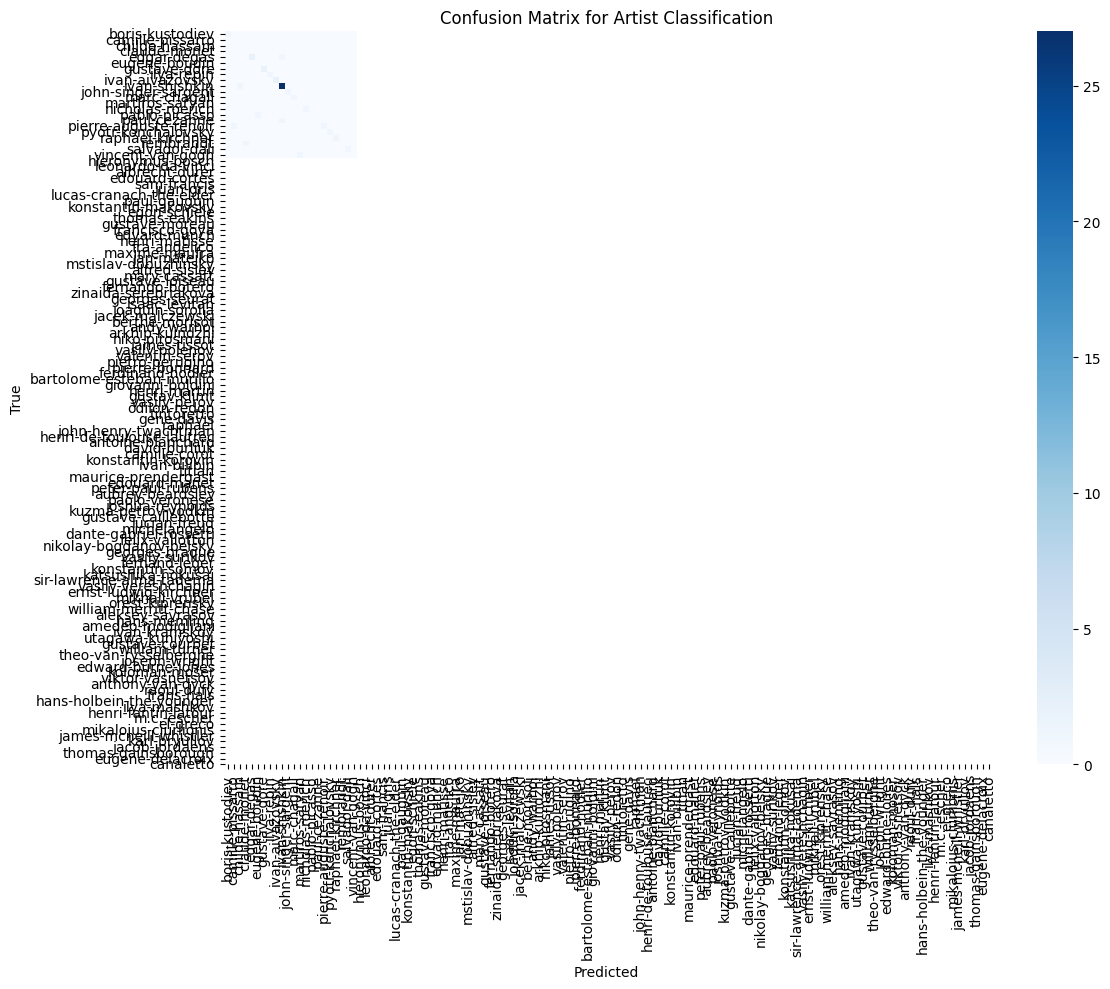

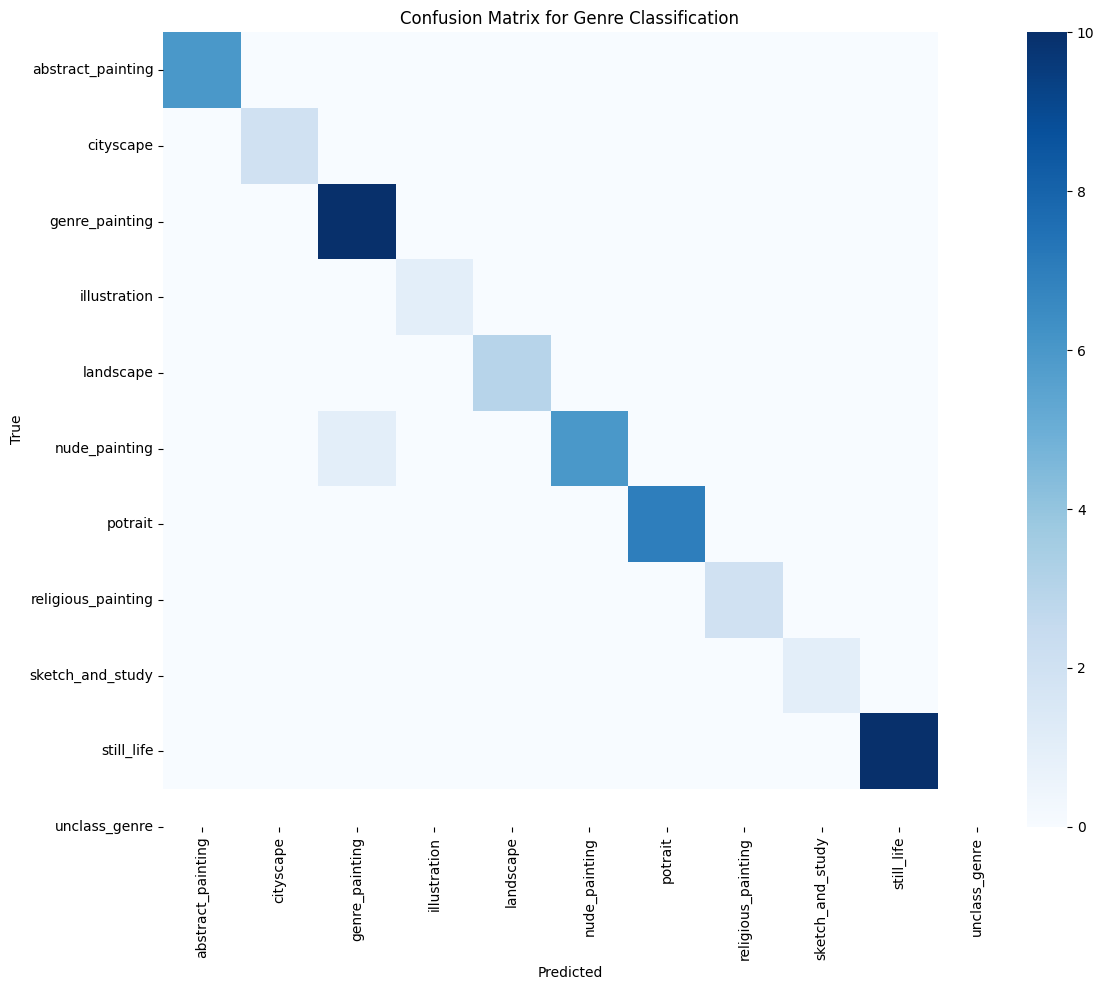

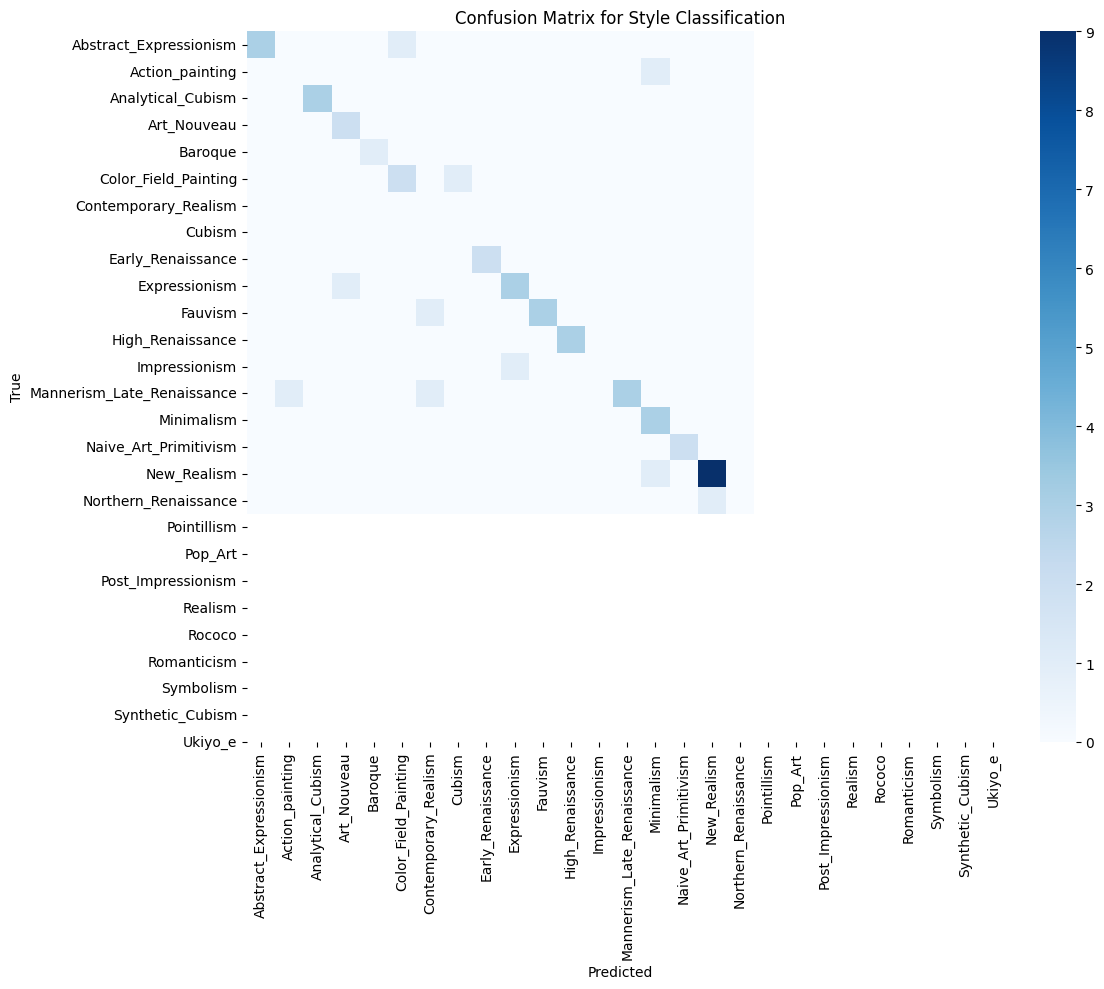

In [28]:
plot_conf_matrix(model, test_loader, class_names=artist_classes, task="artist")
plot_conf_matrix(model, test_loader, class_names=genre_classes, task="genre")
plot_conf_matrix(model, test_loader, class_names=style_classes, task="style")


In [54]:
## SANITY CHECK FOR TRAIN_DATA

from collections import Counter
import pandas as pd

df = pd.read_csv(r"F:\GSoc_2025\cleaned_dataset.csv")
artist_counts = Counter(df['artist'])

print("Top 10 artists by number of images:")
for artist, count in artist_counts.most_common(10):
    print(f"{artist_classes[artist]}: {count} images")  
    


Top 10 artists by number of images:
boris-kustodiev: 41914 images
hieronymus-bosch: 1889 images
pablo-picasso: 1819 images
pyotr-konchalovsky: 1400 images
edgar-degas: 1334 images
raphael-kirchner: 919 images
childe-hassam: 887 images
marc-chagall: 784 images
salvador-dali: 776 images
martiros-saryan: 765 images


In [39]:
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

def find_outlier_samples(model, dataloader, task="artist", num_samples=5):
    model.eval()
    outliers = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            task_index = {"artist": 0, "genre": 1, "style": 2}[task]
            targets = labels[:, task_index].to(device)

            outputs = model(images)[task_index]
            probs = F.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, dim=1)

            for img, conf, pred, true in zip(images, confidences, preds, targets):
                if pred != true:
                    outliers.append((conf.item(), img.cpu(), int(true.cpu()), int(pred.cpu())))

    # Sort by lowest confidence
    outliers = sorted(outliers, key=lambda x: x[0])[:num_samples]

    # Plot
    plt.figure(figsize=(15, 5))
    for idx, (conf, img, true, pred) in enumerate(outliers):
        plt.subplot(1, num_samples, idx+1)
        plt.imshow(TF.to_pil_image(img))
        plt.title(f"True: {true} | Pred: {pred}\nConf: {conf:.2f}")
        plt.axis("off")
    plt.suptitle(f"Low Confidence Misclassifications ({task.capitalize()})")
    plt.show()


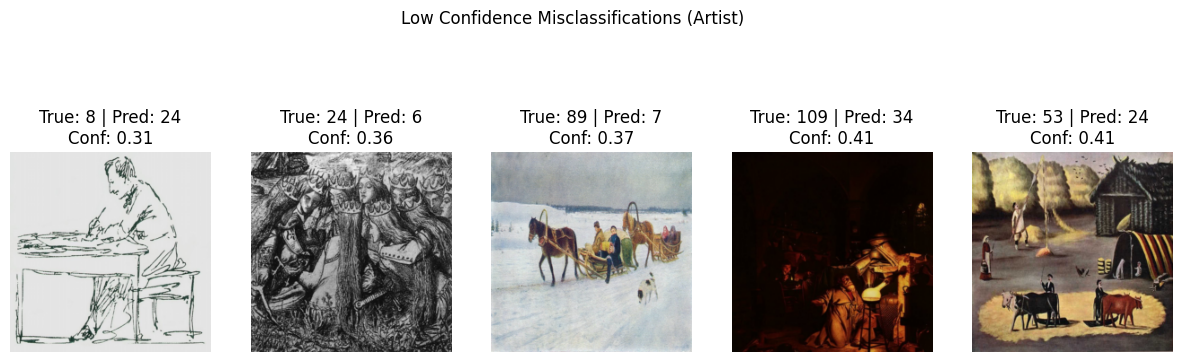

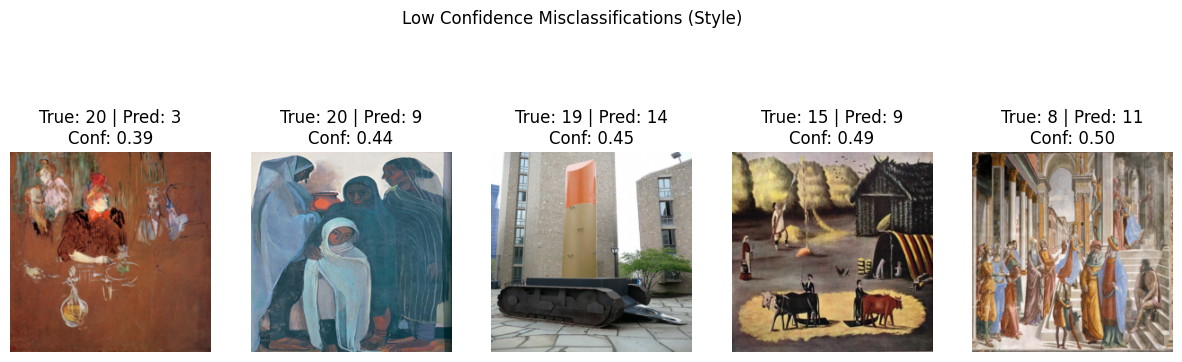

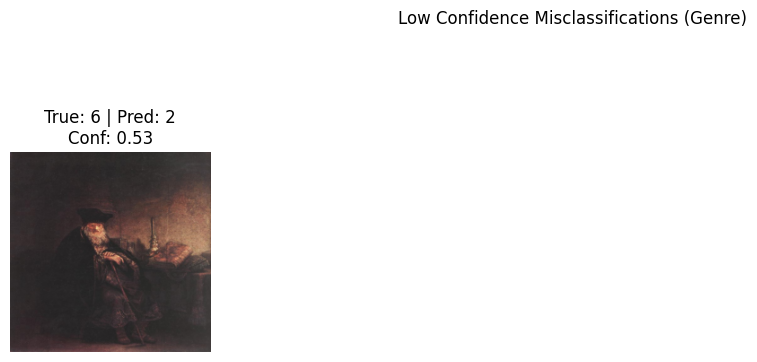

In [40]:
find_outlier_samples(model, test_loader, task="artist")
find_outlier_samples(model, test_loader, task="style")
find_outlier_samples(model, test_loader, task="genre")

### PCA Of DATASET

In [41]:
def extract_features(self, x):
    with torch.no_grad():
        # replicate forward() steps up to before the final classifier
        # assuming CNN + LSTM → you extract the feature vector just before FC layers
        cnn_out = self.cnn(x)  # (B, C, H, W)
        cnn_out = cnn_out.view(cnn_out.size(0), cnn_out.size(1), -1)  # flatten
        cnn_out = cnn_out.permute(0, 2, 1)  # (B, sequence_len, feature_dim)

        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = lstm_out[:, -1, :]  # last hidden state
        return lstm_out  # (B, hidden_dim)


In [47]:
# Setup
model.eval()
features = []
labels = []
images = []

# We'll hook the last layer of ResNet inside your feature_extractor
extracted_feats = []

def hook_fn(module, input, output):
    # output shape: (B, 512, H, W) → flatten spatial dims
    batch_size = output.shape[0]
    out_flat = output.view(batch_size, 512, -1).mean(dim=2)  # Global Average Pooling
    extracted_feats.append(out_flat.detach().cpu())

# Register hook on the last submodule in the ResNet feature extractor
hook = model.feature_extractor[-1].register_forward_hook(hook_fn)

# Forward loop
for i, (img_batch, label_batch) in enumerate(test_loader):
    if len(features) > 1000:
        break

    img_batch = img_batch.to(device)
    with torch.no_grad():
        model(img_batch)  # just forward to trigger the hook

    features.append(torch.cat(extracted_feats, dim=0))
    extracted_feats.clear()

    labels.extend(label_batch[:, 0].cpu().tolist())

    for img_tensor in img_batch.cpu():
        img_np = img_tensor.permute(1, 2, 0).numpy()
        images.append(img_np)

# Combine features
features = torch.cat(features).numpy()

# PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.offsetbox as offsetbox
import numpy as np

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("PCA of Artist Embeddings")

shown_images = np.array([[1., 1.]])
for i in range(len(features_2d)):
    dist = np.sum((features_2d[i] - shown_images) ** 2, 1)
    if np.min(dist) < 4e-3:
        continue
    shown_images = np.r_[shown_images, [features_2d[i]]]

    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(images[i], zoom=0.3),
        features_2d[i]
    )
    ax.add_artist(imagebox)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

# Clean up
hook.remove()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10927941..1.0000004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0014417908..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12896183..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


In [48]:
import os
from torchvision.utils import save_image
from torchvision import transforms as T

# Create output folders
base_dir = "classification_samples"
os.makedirs(f"{base_dir}/correct_all", exist_ok=True)
os.makedirs(f"{base_dir}/correct_two", exist_ok=True)
os.makedirs(f"{base_dir}/correct_one", exist_ok=True)

# Image denormalization (if you used normalization)
denorm = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

model.eval()
with torch.no_grad():
    for idx, (img_batch, label_batch) in enumerate(test_loader):
        img_batch = img_batch.to(device)
        label_batch = label_batch.to(device)  # shape: (B, 3)

        out_artist, out_genre, out_style = model(img_batch)

        pred_artist = torch.argmax(out_artist, dim=1)
        pred_genre = torch.argmax(out_genre, dim=1)
        pred_style = torch.argmax(out_style, dim=1)

        for i in range(img_batch.size(0)):
            true = label_batch[i]
            pred = (pred_artist[i], pred_genre[i], pred_style[i])

            correct = sum([
                pred[0] == true[0],
                pred[1] == true[1],
                pred[2] == true[2]
            ])

            img = denorm(img_batch[i].cpu())
            img = torch.clamp(img, 0, 1)  # keep image valid

            if correct == 3:
                save_image(img, f"{base_dir}/correct_all/img_{idx}_{i}.jpg")
            elif correct == 2:
                save_image(img, f"{base_dir}/correct_two/img_{idx}_{i}.jpg")
            elif correct == 1:
                save_image(img, f"{base_dir}/correct_one/img_{idx}_{i}.jpg")

        if idx > 50:
            break  # prevent saving too many if testing
